# City Growth Classification and Prediction
## Alexander Edstrom
### University Of Minnesota Fall 2021

>Please see the attached README file for a general overview of this project as this jumps right into the code

>This first cell just imports all of the required packages


Shapely and Rasterio are the main packages used within the functions used to cut the raster up <br>TensorFlow is the main package that the image classifier uses 

In [ ]:
import numpy as np
import rasterio
from shapely import geometry
from rasterio.mask import mask
from PIL import Image

import itertools
import os
import matplotlib.pylab as plt
#import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.7.0
Hub version: 0.12.0
GPU is available


>This cell is a collection of functions that take in a raster image (in .tif form) and splice it into cells of a given size (in this case 512x512 for the image classifier

##### I have done this step for you already, the original massive tif is not included within the project files. I have included a few of the cells for you to run a demo with if you want. See the README for details

In [ ]:
# This cell was adapted from Ciaran Evans on GIS Stack Exchange (https://gis.stackexchange.com/users/92704/ciaran-evans)

test_file = "Clip18F.tif"
dataset = rasterio.open(test_file)

# Takes a Rasterio dataset and splits it into squares of dimensions squareDim * squareDim (again in this case it is 512x512 for the image clasifier)
def splitImageIntoCells(img, filename, squareDim):
    numberOfCellsWide = img.shape[1] // squareDim
    numberOfCellsHigh = img.shape[0] // squareDim
    x, y = 0, 0
    count = 0
    for hc in range(numberOfCellsHigh):
        y = hc * squareDim
        for wc in range(numberOfCellsWide):
            x = wc * squareDim
            geom = getTileGeom(img.transform, x, y, squareDim)
            getCellFromGeom(img, geom, filename, count)
            count = count + 1

# Generate a bounding box from the pixel-wise coordinates using the original datasets transform property
def getTileGeom(transform, x, y, squareDim):
    corner1 = (x, y) * transform
    corner2 = (x + squareDim, y + squareDim) * transform
    return geometry.box(corner1[0], corner1[1],
                        corner2[0], corner2[1])

# Crop the dataset using the generated box and write it out as a GeoTIFF
def getCellFromGeom(img, geom, filename, count):
    crop, cropTransform = mask(img, [geom], crop=True)
    writeImageAsGeoTIFF(crop,
                        cropTransform,
                        img.meta,
                        img.crs,
                        filename+"_"+str(count))

# Write the passed in dataset as a GeoTIFF
def writeImageAsGeoTIFF(img, transform, metadata, crs, filename):
    metadata.update({"driver":"GTiff",
                     "height":img.shape[1],
                     "width":img.shape[2],
                     "transform": transform,
                     "crs": crs})
    with rasterio.open(filename+".tif", "w", **metadata) as dest:
        dest.write(img)

#Run the functions on the given dataset with the specified size
splitImageIntoCells(dataset,'Clip18F.tif', 512)

### External Step Required:
#### The cell above outputs the spliced raster cells as .tif files and the image classifier below only takes certain image file formats. As a result, the images needed to be converted into .jpg files first. I did this manually using an application that will convert them in batches. I know this is something that could certainly be done within the scope of the notebook but I was not able to get my conversion function working.

## Beginning of the image classifier section
This image classifier workflow and code is taken from a TensorFlow tutorial (https://www.tensorflow.org/hub/tutorials/tf2_image_retraining).<br>The main idea behind using a premade model is that we can leverage the concept of transfer learning by utilizing a model built for something similar, in this case image identification to classify flowers.
>This cell selects the classification model that will be used to retrain into our classification model


Tensorflow Hub gives accsses to hundreds of different models to train off of but after lots of research and trail and error it seems that the one that the Google tutorial was using to begin with worked the best for this purpose, the Efficient V2 XL 21k model.<br>


In [ ]:
model_name = "efficientnetv2-xl-21k"

model_handle_map = {
"efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2"}

model_image_size_map = {"efficientnetv2-xl-21k": 512}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

IMAGE_SIZE = (pixels, pixels)

print(f"Selected model: {model_name} : {model_handle}")

print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


After the data was converted to .jpg, I sorted a portion of it into two classes to use as the training and validation data. I did this by using supervised pixel based random trees classification and change detection within ArcPro to determine what percentage of pixels had changed between a classification of this image and an image of the same location from 1 year later. All images were taken from Sentinal 2. If the change in the given cell was larger than 12% I added it to my "change" group. If not, it went into the "same" group.

> This cell pulls the data in, and builds a dataset using the data. The data is seperated into two folders "change" and "same" before this step. It takes in a folder of folders for this input. In this example "ph_photos" is the folder that contains "change" and "same" folders.

In [ ]:
data_dir = (r'Final Project/phPhotos') # Depending on where you have the notebook saved you may need to change this path if you want to run it yourself

def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 20 files belonging to 3 classes.
Using 16 files for training.
Found 20 files belonging to 3 classes.
Using 4 files for validation.


>This cell builds the model that was selected a couple cells up and defines the parameters to do so, both the dropout rate and regularization are choosen in this step. I also have it print a small summary of the model to see the layers and parameter count (That's a lot of parameters!).

In [ ]:
# This fine tuning option should be turned on for doing a real run of the program, but for this demo I have turend it off to speed things up
do_fine_tuning = False
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 207,619,675
Trainable params: 3,843
Non-trainable params: 207,615,832
_________________________________________________________________


>The following cell simply compiles and trains the model, this is where you specify the other parameters not set within the building step. Hyperparameters like learning rate and momentum are set here, as well as the amount of epochs and the number of steps per epoch. For this demo it has been ran with 30 epochs.

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=30, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/30
1/1 [==============================] - 53s 53s/step - loss: 1.8142 - accuracy: 0.0625
Epoch 2/30
1/1 [==============================] - 3s 3s/step - loss: 0.8576 - accuracy: 0.6250
Epoch 3/30
1/1 [==============================] - 3s 3s/step - loss: 0.8931 - accuracy: 0.6250
Epoch 4/30
1/1 [==============================] - 3s 3s/step - loss: 1.0775 - accuracy: 0.5625
Epoch 5/30
1/1 [==============================] - 3s 3s/step - loss: 0.9036 - accuracy: 0.6875
Epoch 6/30
1/1 [==============================] - 3s 3s/step - loss: 1.1011 - accuracy: 0.5625
Epoch 7/30
1/1 [==============================] - 3s 3s/step - loss: 1.0181 - accuracy: 0.6875
Epoch 8/30
1/1 [==============================] - 3s 3s/step - loss: 0.9390 - accuracy: 0.7500
Epoch 9/30
1/1 [==============================] - 3s 3s/step - loss: 1.3403 - accuracy: 0.6875
Epoch 10/30
1/1 [==============================] - 3s 3s/step - loss: 0.9664 - accuracy: 0.8125
Epoch 11/30
1/1 [==============================

>This set of functions plots out the training results on a graph to better visualize the accuracy and loss as the model goes through its training steps.

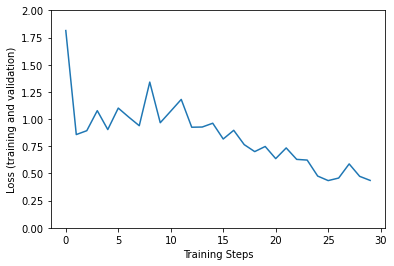

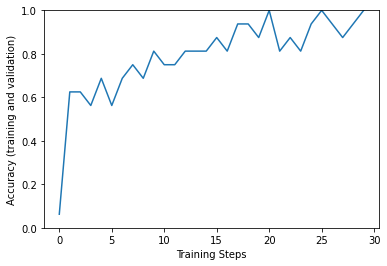

In [ ]:

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])

>Here is where the magic happens! This cell takes in an image that it didn't use for training and trys to guess what class it is. It will take the next vaildation image and make a prediction. After being sent through the model an entire image could be stitched back together to have each cell labeled as change or no change.

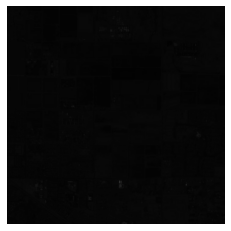

True label: change
Predicted label: change


In [ ]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])